# FWI using TensorFlow: Attempt 2
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](www.ausargeo.com))*

In [Attempt 1](https://github.com/ar4/nnfwi_1d/blob/master/notebooks/nnfwi_1layer.ipynb), I provided receiver data as input to a deep neural network, and tried to get it to output the velocity model that generated the data. This seemed like the most obvious way of applying machine learning to the problem of inverting seismic data, and it worked moderately well. The second most obvious method is what I explore in this notebook.

TensorFlow is typically used to build and train deep neural networks, but it can also do other things. My [finite difference TensorFlow wave propagator](https://github.com/ar4/wave_1d_fd_tf/blob/master/notebooks/wave_1d_fd_tf.ipynb) is probably one of the more unusual of these things, since it doesn't even involve any machine learning. In this attempt I won't be using any neural networks, but I will at least be using TensorFlow to do some learning.

The idea is that I will do something resembling the conventional FWI algorithm using TensorFlow. By using TensorFlow to forward propagate the source wave through the current model, I can record the wavefield at the receiver locations, compare this with the true receiver data, and allow the optimisation algorithm to update the model to reduce the misfit. The nice part about using TensorFlow to do this is that it works out the model gradient from the computational graph itself. I tell it how to do the forward propagation, and it handles everything else by itself.

In [1]:
import numpy as np
from wave_1d_fwi_tf import fwi, test_wave_1d_fwi_tf

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

I'm going to use a very simple 1D model to test this one: 1500 m/s for the top half, and 2500 m/s for the bottom half. The initial model that I provide to the inversion is a constant 1500 m/s. To help reduce the non-uniqueness, I use the data from two receivers: one at the top and one at the bottom of the model, so both reflected and transmitted waves are recorded. It's unrealistic, but since it's our first try with the method, let's use something that we hope it should certainly be able to do a good job on.

In [3]:
model=test_wave_1d_fwi_tf.model_one()

A lot of the work is done in the cell below. This is where the computational graph, which describes how to forward propagate the source wave through the model, is defined. The graph is quite large, since it contains each time step, and so takes a while to build. No actual propagation takes place in this step, only telling TensorFlow how to do the propagation.

In [4]:
y = fwi.TFFWI(np.ones(len(model['model']), np.float32)*1500,                                
              model['sources'], model['sx'],                             
              model['data'], model['rx'], model['nsteps'],
              model['dx'], model['dt'])

Let's take a look at the gradient that TensorFlow computes.

As you can see from the plot below, which has depth on the x axis and model gradient amplitude on the y axis, TensorFlow has determined that to reduce the loss, the velocity in the centre of the model (the location of the reflector) needs to change. In reality, the whole bottom half of the model needs to change (from the 1500 m/s of the initial model to the true 2500 m/s), but only making a change at the reflector location is the same as what I would expect conventional FWI to do.

In the computational graph that was created above, I did have to do one little extra thing in addition to telling TensorFlow how to forward propagate: I had to overwrite the gradient in the PML (perfectly matched layer - the absorbing boundary) regions with the gradient at the first non-PML cell. If I don't do that, the gradient explodes there. I'm not completely sure why this happens, but I suspect it is because the PML forces the wave amplitude to zero there, and so infinitely large reflectors would be needed to generate the recorded arrivals. There are still some little blips at the boundaries, but they are now much smaller than the gradient in the centre of the model.

In [5]:
y.sess.run(y.init)

grad = y.sess.run(y.y_grad)

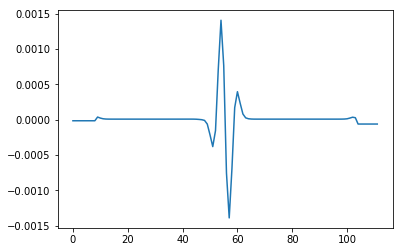

In [7]:
plt.plot(grad)

Since the gradient looks reasonable, let's try running the optimization for 2000 iterations.

The numbers show the iteration number and the value of the loss. The loss declines quite quickly at first, but then slows down considerably after 400 iterations. It continues to make progress, but I don't think the results would be significantly different if I ran for more than 2000 iterations.

In [5]:
pred_y, pred_model=y.invert(nsteps=2000)

0 28.4814
20 27.2304
40 25.4297
60 24.9956
80 24.6908
100 24.4482
120 24.2076
140 23.9131
160 23.4631
180 21.5585
200 20.5038
220 20.3109
240 20.1566
260 19.9373
280 19.5916
300 19.0921
320 18.6795
340 18.0487
360 17.9002
380 17.7746
400 17.6665
420 17.5889
440 17.5374
460 17.5007
480 17.4723
500 17.4494
520 17.4303
540 17.4143
560 17.4006
580 17.3889
600 17.3789
620 17.3703
640 17.3629
660 17.3564
680 17.3506
700 17.3456
720 17.3411
740 17.3371
760 17.3335
780 17.3303
800 17.3275
820 17.325
840 17.3228
860 17.3208
880 17.3191
900 17.3175
920 17.3161
940 17.3149
960 17.3137
980 17.3127
1000 17.3117
1020 17.3108
1040 17.31
1060 17.3092
1080 17.3084
1100 17.3077
1120 17.307
1140 17.3063
1160 17.3056
1180 17.305
1200 17.3044
1220 17.3038
1240 17.3032
1260 17.3026
1280 17.3021
1300 17.3015
1320 17.301
1340 17.3005
1360 17.2999
1380 17.2994
1400 17.2989
1420 17.2984
1440 17.298
1460 17.2975
1480 17.297
1500 17.2965
1520 17.2961
1540 17.2957
1560 17.2952
1580 17.2948
1600 17.2944
1620 17.294

## Results

Now for the exciting part. How did it do?

Let's first compare the true receiver data with the computed receiver data in the inverted model. The method has been trying to make these two things match.

You may remember that I used two receivers: one at the top and one at the bottom. The data from both are concatenated (the top receiver data first) and displayed below. The orange line plots the true data and the blue is from the inverted model.

The data for the top receiver includes the direct arrival from the source (the first large wavelet), and the reflected arrival (the small wavelet in the centre of the plot). It looks like the method has done a pretty good job of finding a model that produces data to match this receiver. There's a little bit of extra wiggliness, but the two actual arrivals are both reproduced very accurately.

The bottom receiver only records the transmitted wave, so its recording is mostly zeros. The method seems to have gotten a bit too fond of trying to match these zeros, and the data from the inverted model is in fact zero all the way through the large transmitted arrival. Fail. The result might have been different if I forward propagated for a bit longer, as the current number of timesteps doesn't seem to be enough for the transmitted arrival to arrive at the bottom receiver in the inverted velocity model (you can see the beginning wiggles just starting as the recording ends). This probably made the optimizer reluctant to make the model faster as doing so would start to bring more of the transmitted arrival into the recording, and so, until it gets fast enough to match the true transmitted arrival, would increase the loss function.

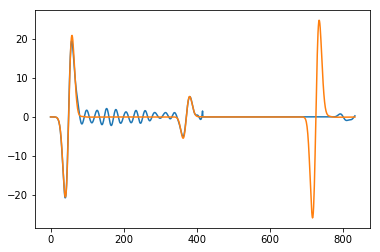

In [6]:
plt.plot(pred_y.reshape(-1))
plt.plot(model['data'].reshape(-1))

Enough looking at recorded data, let's see what we came for: the inverted model. It is plotted below (x axis is depth, y axis is velocity), and... Oh dear. There is a spike at about the correct depth for where the velocity steps up in the true model, and the velocity above that stayed about right (it was already correct in the initial model), but the lower half of the model has very much failed to reach the true 2500 m/s.

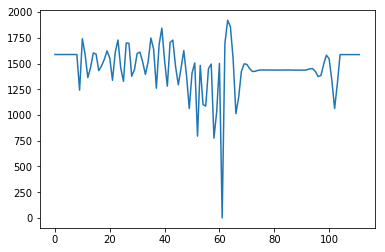

In [7]:
plt.plot(pred_model.reshape(-1))

## Conclusion

Although this was an interesting experiment with TensorFlow, and the results might have been better if I forward propagated for more time steps (so the transmitted wave was recorded in the initial model), the slow runtime and large memory usage of this method mean that it is probably impractical for anything other than small toy problems like this.